# QR-разложение вращениями Гивенса

## 0. Общая часть

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg.blas
import mymodule
import math
from numba import njit

In [2]:
scipy.ALLOW_THREADS = 1
np.ALLOW_THREADS = 1

In [3]:
def restore_q(q, dim0, dim1):
    res = np.zeros((dim0, dim1))
    for i in range(min(dim0,dim1)):
        res[i, i] = 1
    iq = q.shape[0] - 1
    for i in range(dim1-1, -1, -1):
        for j in range(dim0-1, i, -1):
            s = q[iq]
            c = q[iq-1]
            scipy.linalg.blas.drot(res[i], res[j], c, -s, offx=i, offy=i, overwrite_x=1, overwrite_y=1)
            iq -= 2
    return res

def test(qr_func):
    eps = 1e-10
    m = 100
    n = 60
    a = np.random.rand(m, n)
    q, r = qr_func(a)
    q = restore_q(q, m, n)
    for i in range(r.shape[0]):
        for j in range(i+1, r.shape[1]):
            if (r[j, i] > eps):
                return 1
    if np.linalg.norm(q@r - a, ord='fro') > eps:
        return 2
    if np.linalg.norm(q.T@q - np.eye(n, n), ord='fro') > eps:
        return 3
    return 0

def compute_times(sizes, qr_func):
    times = []
    for size in sizes:
        a = np.random.rand(size, size)
        t = %timeit -o qr_func(a)
        times.append(t.average)
    return times

In [4]:
sizes = [128, 256, 512, 1024, 2048]

## 1. Python

In [5]:
def compute_params(aii, aji):
    c =  aii / np.sqrt(aii * aii + aji * aji)
    s = -aji / np.sqrt(aii * aii + aji * aji)
    return (c, s)

def rotate(xi, xj, c, s):
    xi_ = xi * c - xj * s
    xj_ = xi * s + xj * c
    return (xi_, xj_)

def qr(a):
    q = []
    r = np.copy(a)
    for i in range(r.shape[1]):
        for j in range(i+1, r.shape[0]):
            c, s = compute_params(r[i, i], r[j, i])
            q.extend([c, -s])
            for k in range(i, r.shape[1]):
                xi, xj = rotate(r[i, k], r[j, k], c, s)
                r[i, k] = xi
                r[j, k] = xj
    return np.asarray(q), r[:r.shape[1]]

In [6]:
test(qr)

0

In [7]:
res1 = compute_times(sizes[:-2], qr)

1.03 s ± 221 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.37 s ± 368 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 2s ± 3.87 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 2. Numpy

In [8]:
def qr_np(a):
    q = []
    r = np.copy(a)
    for i in range(r.shape[1]):
        for j in range(i+1, r.shape[0]):
            c, s = compute_params(r[i, i], r[j, i])
            ri = r[i] * c - r[j] * s
            rj = r[i] * s + r[j] * c
            r[i] = ri
            r[j] = rj
            q.extend([c, -s])
    return np.asarray(q), r[:r.shape[1]]

In [9]:
test(qr_np)

0

In [10]:
res2 = compute_times(sizes[:-1], qr_np)

93.4 ms ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
590 ms ± 63.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.88 s ± 835 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.9 s ± 331 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 3. Numpy + Numba

In [11]:
@njit
def qr_np_numba(a):
    q = []
    r = np.copy(a)
    for i in range(r.shape[1]):
        for j in range(i+1, r.shape[0]):
            c =  r[i,i] / np.sqrt(r[i,i] * r[i,i] + r[j,i] * r[j,i])
            s = -r[j,i] / np.sqrt(r[i,i] * r[i,i] + r[j,i] * r[j,i])
            ri = r[i] * c - r[j] * s
            rj = r[i] * s + r[j] * c
            r[i] = ri
            r[j] = rj
            q.extend([c, -s])
    return np.asarray(q), r[:r.shape[1]]

In [12]:
test(qr_np_numba)

0

In [13]:
res3 = compute_times(sizes, qr_np_numba)

4.65 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
37.2 ms ± 359 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
223 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.52 s ± 254 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
13 s ± 1.86 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 4. Numba

In [14]:
@njit
def qr_numba(a):
    r = np.copy(a)
    q = []
    for i in range(r.shape[1]):
        for j in range(i+1, r.shape[0]):
            c =  r[i,i] / np.sqrt(r[i,i] * r[i,i] + r[j,i] * r[j,i])
            s = -r[j,i] / np.sqrt(r[i,i] * r[i,i] + r[j,i] * r[j,i])
            q.extend([c, -s])
            for k in range(i, r.shape[1]):
                xi = r[i, k]
                xj = r[j, k]
                r[i, k] = xi * c - xj * s
                r[j, k] = xi * s + xj * c
    return np.asarray(q), r[:r.shape[1]]

In [15]:
test(qr_numba)

0

In [16]:
res4 = compute_times(sizes, qr_numba)

3.22 ms ± 42.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.2 ms ± 3.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
113 ms ± 28.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.02 s ± 166 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.54 s ± 713 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 5. SciPy

In [17]:
def qr_sp(a):
    r = np.copy(a)
    q = []
    for i in range(r.shape[1]):
        for j in range(i+1, r.shape[0]):
            c, s = scipy.linalg.blas.drotg(r[i,i], r[j,i])
            scipy.linalg.blas.drot(r[i], r[j], c, s, offx=i, offy=i, overwrite_x=1, overwrite_y=1)
            q.extend([c, s])
    return np.asarray(q), r[:r.shape[1]]

In [18]:
test(qr_sp)

0

In [19]:
res5 = compute_times(sizes, qr_sp)

26.4 ms ± 8.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
112 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
498 ms ± 8.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.13 s ± 401 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.9 s ± 1.49 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 6. C (swig)

In [20]:
def qr_c(a):
    m = a.shape[0]
    n = a.shape[1]
    q_size = 2*int((2*m-n-1)*n/2)
    q = np.empty(q_size)
    r = np.empty((n, n))
    mymodule.qr(a, q, r)
    return q, r

In [21]:
test(qr_c)

0

In [22]:
res6 = compute_times(sizes, qr_c)

958 µs ± 55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.94 ms ± 672 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
46.1 ms ± 4.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
413 ms ± 54.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.54 s ± 251 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 7. Сравнение функций

In [23]:
labels = ['Python', 'NumPy', 'Numpy + Numba', 'Numba', 'SciPy', 'C (swig)']
colors = ['g', 'b', 'r', 'y', 'k', 'c']
log2_sizes = [int(math.log2(size)) for size in sizes]

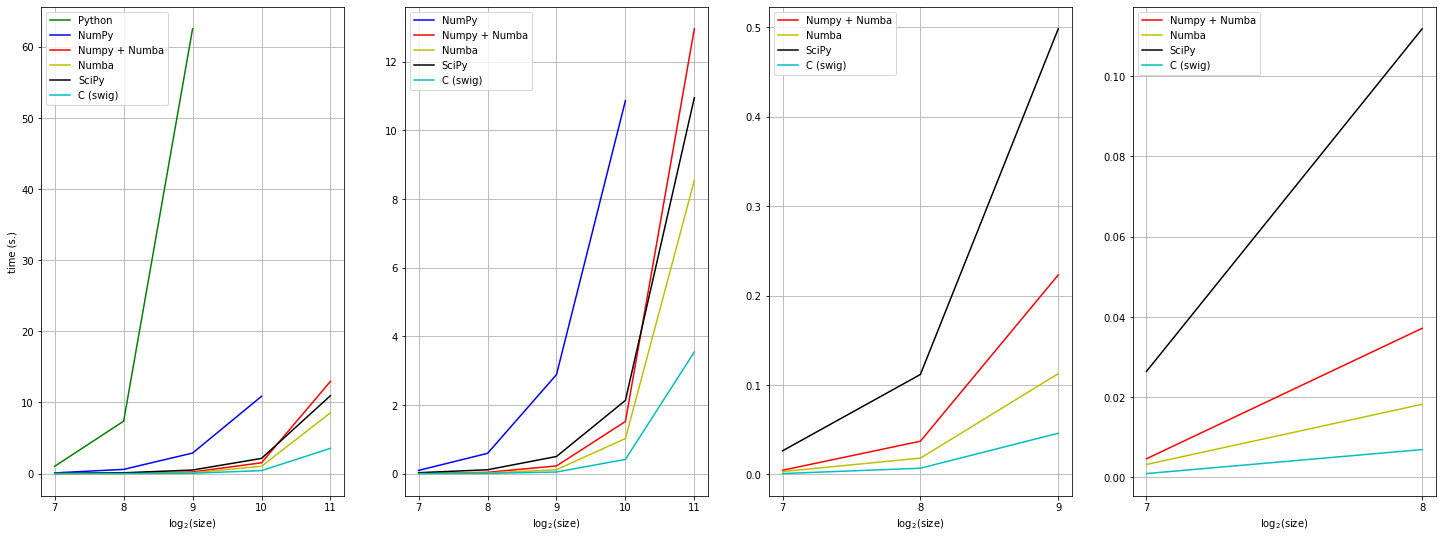

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(25, 9)) # 25,9             
ax[0].plot(log2_sizes[:-2], res1, label=labels[0], color=colors[0])
for j in range(2):
    ax[j].plot(log2_sizes[:-1], res2, label=labels[1], color=colors[1])
    for i in range(2, len(labels)):
        ax[j].plot(log2_sizes, eval('res%d'%(i+1)), label=labels[i], color=colors[i])
    ax[j].set_xticks(log2_sizes)
for j in range(2, 4):
    for i in range(2, len(labels)):
        ax[j].plot(log2_sizes[:-j], eval('res%d'%(i+1))[:-j], label=labels[i], color=colors[i])
        ax[j].set_xticks(log2_sizes[:-j])
for i in range(4):
    ax[i].grid()
    ax[i].set_xlabel(r'$\log_2$(size)')
    ax[i].legend(loc='upper left')
ax[0].set_ylabel('time (s.)')
plt.subplots_adjust(wspace=0.2)

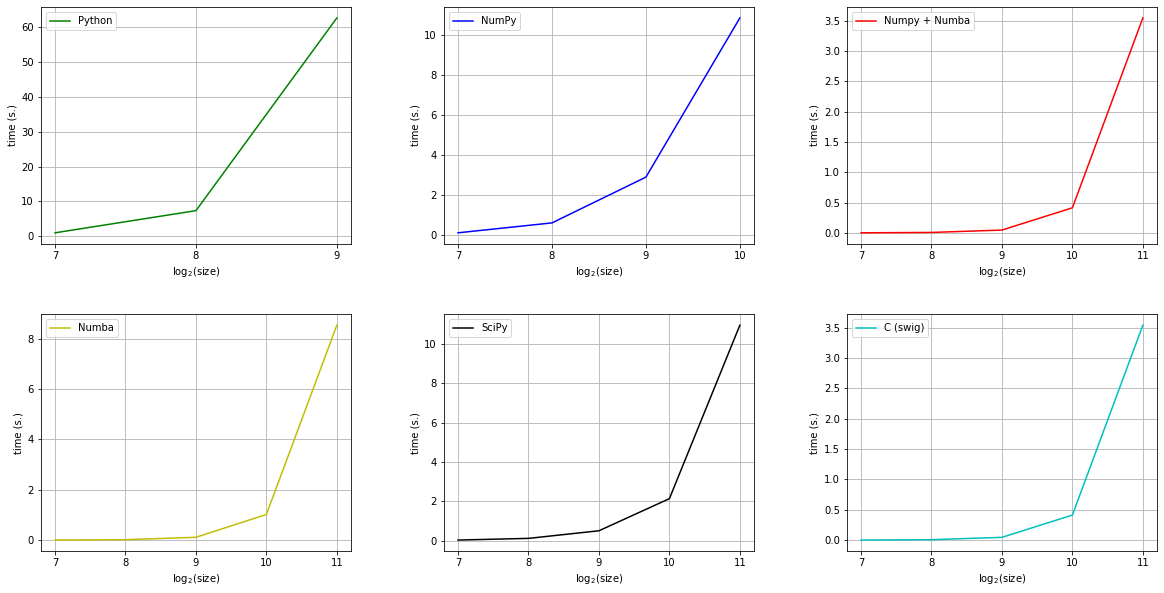

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i in range(2):
    ax[0, i].plot(log2_sizes[:-2+i], eval('res%d'%(i+1)), label=labels[i], color=colors[i])
    ax[0, i].set_xticks(log2_sizes[:-2+i])    
for i in range(2):
    for j in range(2-2*i, 3):
        ax[i, j].plot(log2_sizes, eval('res%d'%(3+j+1)), label=labels[3*i+j], color=colors[3*i+j])
        ax[i, j].legend(loc='upper left')
        ax[i, j].set_xticks(log2_sizes)
for i in range(2):
    for j in range(3):
        ax[i, j].grid()
        ax[i, j].set_xlabel(r'$\log_2$(size)')
        ax[i, j].set_ylabel('time (s.)')
        ax[0, i].legend(loc='upper left')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()